## Setup

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os
import time
import json
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets

import config
from utils import *

os.environ['OPENAI_API_KEY'] = config.OPENAI_API_KEY

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## debug main

In [20]:
dataset = load_dataset(config.DATASET_NAME)
all_data = concatenate_datasets([dataset['test'], dataset['validation']])

In [21]:
print(all_data)

Dataset({
    features: ['name', 'formal_statement', 'informal_statement', 'tags', 'header', 'split'],
    num_rows: 4
})


In [22]:
item = all_data[0]
print(item)

results = []

{'name': 'f2f_numbertheory_4x3m7y3neq2003', 'formal_statement': 'theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 := by\n', 'informal_statement': '/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/\n', 'tags': "['number_theory']", 'header': 'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n', 'split': 'test'}


In [23]:
informal_statement = item['informal_statement']
print(informal_statement)

/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/



In [47]:
print(generate_prompt(informal_statement, few_shot_examples=[]))

You are an expert in formalizing mathematical statements in Lean 4. Given the following informal mathematical statement, write the corresponding formal statement in Lean 4 syntax.
Output format: The translated LEAN 4 theorem should be provided as a single cohesive code block, displaying the correct syntax and formatting expected for a LEAN 4 theorem statement. Do not enclose the code block in backticks. write sorry as the proof.



Informal statement:
/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/


Formal statement in Lean 4:


In [48]:
response = translate_statement(
    informal_statement,
    few_shot_examples = [],
    model=config.DEFAULT_MODEL,
    temperature=0.0,
    max_tokens=500,
)

[{'role': 'user', 'content': 'You are an expert in formalizing mathematical statements in Lean 4. Given the following informal mathematical statement, write the corresponding formal statement in Lean 4 syntax.\nOutput format: The translated LEAN 4 theorem should be provided as a single cohesive code block, displaying the correct syntax and formatting expected for a LEAN 4 theorem statement. Do not enclose the code block in backticks. write sorry as the proof.\n\n\n\nInformal statement:\n/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/\n\n\nFormal statement in Lean 4:'}]


In [49]:
print(response)

ModelResponse(id='chatcmpl-AHzGeh7JadO3x5hvQFbfZ3TjD2tA2', choices=[Choices(finish_reason='stop', index=0, message=Message(content='theorem no_integers_solution : ¬ ∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 := \nsorry', role='assistant', tool_calls=None, function_call=None))], created=1728850452, model='gpt-4o-2024-08-06', object='chat.completion', system_fingerprint='fp_a20a4ee344', usage=Usage(completion_tokens=39, prompt_tokens=137, total_tokens=176, completion_tokens_details=CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=None, cached_tokens=0)), service_tier=None)


In [51]:
formal_statement = response.choices[0].message.content
print(formal_statement)

theorem no_integers_solution : ¬ ∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 := 
sorry


In [52]:
results.append({
    'name': item['name'],
    'informal_statement': informal_statement,
    'generated_formal_statement': formal_statement,
    'formal_statement': item['formal_statement'],
    'tags': item['tags'],
    'header': item['header'],
    'split': item['split'],
    'model': config.DEFAULT_MODEL,
    'provider': config.DEFAULT_PROVIDER,
})

In [53]:
results

[{'name': 'f2f_numbertheory_4x3m7y3neq2003',
  'informal_statement': '/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/\n',
  'generated_formal_statement': 'theorem no_integers_solution : ¬ ∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 := \nsorry',
  'formal_statement': 'theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 := by\n',
  'tags': "['number_theory']",
  'header': 'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n',
  'split': 'test',
  'model': 'gpt-4o',
  'provider': 'openai'}]

In [59]:
output_file = os.path.join(config.RESULTS_DIR, f"{config.OUTPUT_NAME}_{config.DEFAULT_MODEL}.json")

with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results have been saved to {output_file}")

Results have been saved to results/evaluation/baseline_direct_translation_gpt-4o.json


## checking results

In [72]:
json_file_path = 'results/generations/baseline_direct_translation_gpt-4o.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,name,informal_statement,generated_formal_statement,formal_statement,tags,header,split,model,provider
0,f2f_numbertheory_4x3m7y3neq2003,/-- Show that there are no integers $x$ and $y...,"theorem no_integers_solution : ¬ ∃ (x y : ℤ), ...",theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
1,f2f_mathd_numbertheory_3,/-- What is the units digit of the sum of the ...,theorem units_digit_sum_squares_first_nine : \...,theorem mathd_numbertheory_3 : (∑ x in Finset....,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
2,f2f_mathd_numbertheory_1124,/-- The four-digit number $\underline{374n}$ i...,theorem find_units_digit (n : ℕ) (h : 0 ≤ n ∧ ...,theorem mathd_numbertheory_1124 (n : ℕ) (h₀ : ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
3,f2f_mathd_numbertheory_237,/-- What is the modulo $6$ remainder of the su...,theorem sum_mod_6_remainder : (∑ i in finset.r...,theorem mathd_numbertheory_237 : (∑ k in Finse...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
4,f2f_mathd_numbertheory_299,/-- What is the ones digit of $1 \cdot 3 \cdot...,theorem ones_digit_of_product_is_five : \n (1...,theorem mathd_numbertheory_299 : 1 * 3 * 5 * 7...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai


### Length

In [73]:
# Calculate the length of each 'generated_formal_statement'
df['gen_formal_stmt_length'] = df['generated_formal_statement'].apply(len)

# Compute the average length
average_length = df['gen_formal_stmt_length'].mean()
print(f"Average length of generated_formal_statement: {average_length:.2f} characters")


Average length of generated_formal_statement: 159.52 characters


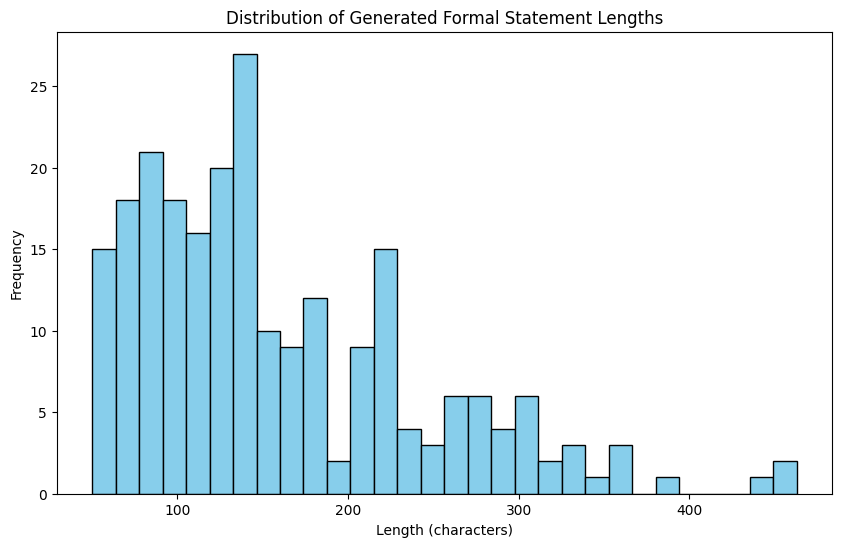

In [74]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(df['gen_formal_stmt_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Generated Formal Statement Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

### Sorry

In [75]:
# Define a function to check if text ends with 'sorry' (case-insensitive, optional punctuation)
def ends_with_sorry(text):
    text = text.strip()
    pattern = re.compile(r'sorry[\.\!\?]?$', re.IGNORECASE)
    return bool(pattern.search(text))

# Apply the function to the DataFrame
df['ends_with_sorry'] = df['generated_formal_statement'].apply(ends_with_sorry)

# Filter the DataFrame for statements that do not end with 'sorry'
not_sorry_df = df[~df['ends_with_sorry']]

# Reset the index
not_sorry_df = not_sorry_df.reset_index(drop=True)

# Display the number of examples
print(f"Number of statements not ending with 'sorry': {len(not_sorry_df)}")

# Display the first few examples
not_sorry_df[['name', 'generated_formal_statement']].head()

Number of statements not ending with 'sorry': 15


,name,generated_formal_statement
0,putnam_1971_b6,theorem greatest_odd_divisor_sum_bound (x : ℕ)...
1,putnam_2002_a5,theorem positive_rationals_in_sequence :\n ∀ ...
2,putnam_1969_b1,```lean\nimport Mathlib.Algebra.Divisibility\n...
3,putnam_2017_a1,theorem not_in_S (n : ℕ) (h : n > 0) : n ∉ S :...
4,putnam_2009_b1,```lean\nimport data.rat.basic\nimport data.na...


In [76]:
# Calculate the length of each 'generated_formal_statement'
not_sorry_df['gen_formal_stmt_length'] = not_sorry_df['generated_formal_statement'].apply(len)

# Compute the average length
average_length_not_sorry = not_sorry_df['gen_formal_stmt_length'].mean()
print(f"Average length of 'not sorry' generated_formal_statement: {average_length_not_sorry:.2f} characters")

Average length of 'not sorry' generated_formal_statement: 296.20 characters


/home/agatha/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


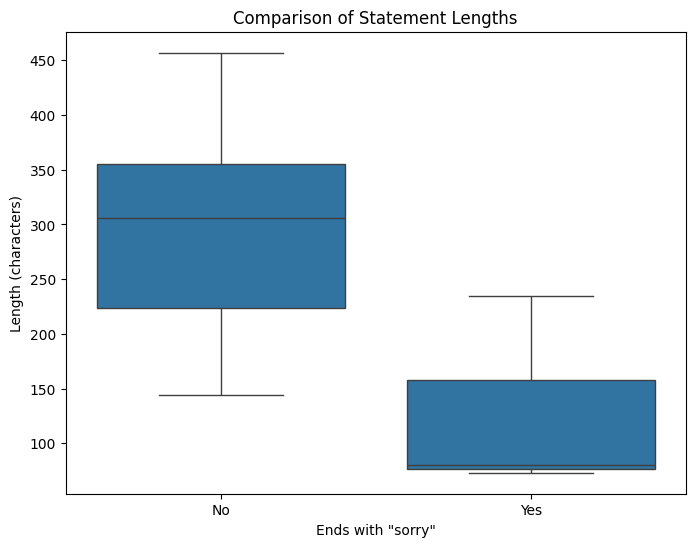

In [77]:
import seaborn as sns

# Combine the lengths into a single DataFrame for plotting
length_comparison_df = pd.DataFrame({
    'Length': not_sorry_df['gen_formal_stmt_length'].tolist() + sorry_df['gen_formal_stmt_length'].tolist(),
    'Ends_with_sorry': ['No'] * len(not_sorry_df) + ['Yes'] * len(sorry_df)
})

# Plot the boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x='Ends_with_sorry', y='Length', data=length_comparison_df)
plt.title('Comparison of Statement Lengths')
plt.xlabel('Ends with "sorry"')
plt.ylabel('Length (characters)')
plt.show()


In [78]:
text = "theorem convergence_of_series (b : \u2115) (hb : b \u2265 2) :\n  \u2203 L : \u211d, \u2203 N : \u2115, \u2200 n \u2265 N, \u2211 i in finset.range n, (1 : \u211d) / (f b i) < L :=\nsorry\n\nwhere\n  f : \u2115 \u2192 \u2115\n  | 1     := 1\n  | 2     := 2\n  | n + 3 := (n + 3) * f b (nat_digits b (n + 3))\n\nand\n  nat_digits : \u2115 \u2192 \u2115 \u2192 \u2115\n  | b n := if n < b then 1 else 1 + nat_digits b (n / b)"
print(text)

theorem convergence_of_series (b : ℕ) (hb : b ≥ 2) :
  ∃ L : ℝ, ∃ N : ℕ, ∀ n ≥ N, ∑ i in finset.range n, (1 : ℝ) / (f b i) < L :=
sorry

where
  f : ℕ → ℕ
  | 1     := 1
  | 2     := 2
  | n + 3 := (n + 3) * f b (nat_digits b (n + 3))

and
  nat_digits : ℕ → ℕ → ℕ
  | b n := if n < b then 1 else 1 + nat_digits b (n / b)
